# Obtain the central positions of high velocity channels

We tried Cote's upper edge code to see if we can estimate a $v_{rot} \propto r^{-0.5}$ but most of the points show a steeper slope, indicative of infall. To estimate the mass there we need a centrifugal barrier which we do not have enough resolution really to limit. 

The next thing to try is to see the peak displacement in the high velocity channels, which trace the high-velocity rotation.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from spectral_cube.spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
import sys
import os
sys.path.append('../')
from B5setup import *
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.constants import G
from astropy.modeling import models, fitting
from spectral_cube import BooleanArrayMask
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
folder = 'gaussfit_2D_C18O/'
smallcubename = 'data/B5IRS1_C18O_robust05_multi_cut.fits'
smallcubenameK = 'data/B5IRS1_C18O_robust05_multi_cut_K.fits'
smallcubenamecorrected = folder + 'B5IRS1_C18O_robust05_multi_cut_K_contcorrected.fits'
smallcubecontcorrectionname = folder + 'B5IRS1_C18O_robust05_multi_cut_K_continuumbase.fits'
# rmsfile = 'cleaned_images/B5IRS1_C18O_robust05_multi_cut_K_contcorrected_rms.fits'
snrfile = 'data/B5IRS1_C18O_robust05_multi_cut_K_contcorrected_SNR.fits'
# centerra, centerdec = ((3+(47+(41.587/60))/60)*15 *u.deg, (32+(51+43.616/60)/60)*u.deg) # center of continuum emission
centerra, centerdec = ra_yso, dec_yso # we try and see what happens without this correction

In [3]:
def distancepix(x, y, x0, y0):
    #supports np.array
    return np.sqrt((x - x0) ** 2 + (y - y0) ** 2)


def get_2dgaussian_with_errors(image, rmsmap, beamsizepix, verbose=False):
    yy, xx = np.mgrid[:len(image), :len(image[0])]
    peakK = np.nanmax(image)
    positionpeaky, positionpeakx = np.unravel_index(np.nanargmax(image), np.shape(image))
    g_model = models.Gaussian2D(amplitude=peakK, x_mean=positionpeakx, y_mean=positionpeaky, x_stddev=beamsizepix, y_stddev=beamsizepix)
    fitter = fitting.LevMarLSQFitter()
    params = fitter(g_model, xx, yy, image, weights=rmsmap)
    if fitter.fit_info['param_cov'] is None or fitter.fit_info['ierr']>4:
        if verbose: 
            print('There was an error with the fit (did not converge or the cov. matrix is empty.')
        return None
    errparams = np.sqrt(np.diag(fitter.fit_info['param_cov'])) # remember there is theta as well!
    return params, errparams, xx, yy, params(xx, yy), positionpeakx, positionpeaky


def fit_line_with_errors(xdata, ydata, weights, slope_init, c_init, verbose=False):
    line_init = models.Linear1D(slope=slope_init, intercept=c_init,fixed={'slope':True, 'intercept':False})
    fitter = fitting.LinearLSQFitter(calc_uncertainties=True)
    params = fitter(line_init, xdata, ydata, weights=weights)
    return params
    
    
def get_indexes_of_limits(array, limitlow, limithigh):
    '''
    This assumes the list is ordered from lower to higher values
    '''
    lowarray = array >= limitlow
    higharray = array <= limithigh
    indexmask = lowarray * higharray
    if not indexmask.any():
        raise ValueError('There are no values in the array within range.')
    indexes = np.where(indexmask)[0]
    lowindex = indexes[0]
    highindex = indexes[len(indexes)-1]
    return lowindex, highindex


In [4]:
# here we prepare the cube: convert units to K, correcting the continuum baseline, calculating Tpeak and rms

# ranges where we believe emission starts
velinit = 7 * u.km / u.s
velend = 13 * u.km / u.s

if not os.path.exists(smallcubenameK):
    print('Creating file in K')
    smallcube = SpectralCube.read(smallcubename).with_spectral_unit(u.km/u.s)
    smallcube.allow_huge_operations=True
    smallcube = smallcube.to(u.K)
    smallcube.write(smallcubenameK)
else:
    smallcube = SpectralCube.read(smallcubenameK).with_spectral_unit(u.km/u.s)
    
# we need to check the baseline because the data might have over-subtracted continuum
if not os.path.exists(smallcubenamecorrected):
    print('Creating continuum correct')
    spectral_axis = smallcube.spectral_axis
    good_channels = (spectral_axis < velinit) | (spectral_axis > velend)  
    masked_cube = smallcube.with_mask(good_channels[:, np.newaxis, np.newaxis])  
    med = masked_cube.median(axis=0)
    if not os.path.exists(smallcubecontcorrectionname):
        med.write(smallcubecontcorrectionname)
    med_subcube = smallcube - med
    med_subcube.write(smallcubenamecorrected)
else:
    med_subcube= SpectralCube.read(smallcubenamecorrected)
    

hdcube = med_subcube.header.copy()
velerror = hdcube['CDELT3'] * 2 / 2.35
key_remove = ['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdcube.remove(key_i)
hdcube['WCSAXES'] = 2
hdcube['NAXIS'] = 2

velinitrms = 4.5 *u.km/u.s
rms = med_subcube.spectral_slab(velinitrms, velinit).unmasked_data[:,:,:].std()
print('RMS of cube: '+str(rms))

    
if not os.path.exists(snrfile):
    print('Creating Signal to Noise Ratio cube')
    snrmap = (med_subcube / rms)
    snrmap.write(snrfile)
else: 
    snrmap = SpectralCube.read(snrfile)

print('Loaded initial files')

RMS of cube: 1.4729372681204078 K
Loaded initial files


In [5]:
# here we cut the cubes in two: blue and red side

velinitblue = 7.9 * u.km / u.s
velendblue = 9.2 * u.km / u.s
# velinitblue = 8.09* u.km / u.s
# velendblue =8.40 * u.km / u.s # this range is to try to fit

velinitred = 10.8 * u.km / u.s
velendred =12.35 * u.km / u.s
# velinitred = 12.0 * u.km / u.s
# velendred =12.3* u.km / u.s

smallcubenameblue = folder + 'B5IRS1_C18O_robust05_multi_cut_K_contcorrected_blue.fits'
smallcubenamered = folder + 'B5IRS1_C18O_robust05_multi_cut_K_contcorrected_red.fits'

# we first cut the cubes in two
if not os.path.exists(smallcubenameblue):
    print('Cutting cube to make blue side cube')
    smallmapblue = med_subcube.spectral_slab(velinitblue, velendblue)
    smallmapblue.write(smallcubenameblue)
else:
    smallmapblue = SpectralCube.read(smallcubenameblue)

if not os.path.exists(smallcubenamered):
    print('Cutting cube to make red side cube')
    smallmapred = med_subcube.spectral_slab(velinitred, velendred)
    smallmapred.write(smallcubenamered)
else:
    smallmapred = SpectralCube.read(smallcubenamered)
print('Blue and red cubes ready')

Blue and red cubes ready


In [6]:
# here we make the mask to choose where to fit
maskcubefileblue = folder + 'B5IRS1_C18O_robust05_multi_cut_K_contcorrected_blue_masked.fits'
maskcubefilered = folder + 'B5IRS1_C18O_robust05_multi_cut_K_contcorrected_red_masked.fits'

if not os.path.exists(maskcubefileblue):
    print('Creating files with masks applied')
    # mask all pixels with SNR<3
    maskcube = BooleanArrayMask(mask=snrmap.unmasked_data[:,:,:]>=3, wcs=smallcube.wcs)
    med_subcube = med_subcube.with_mask(maskcube)
    # mask all pixels farther away from the center of the continuum
    smallcubehead = med_subcube.header
    wcs = WCS(smallcubehead)
    centerxcont = wcs.celestial.wcs_world2pix([centerra.value], [centerdec.value],0)[0][0]
    centerycont = wcs.celestial.wcs_world2pix([centerra.value], [centerdec.value],0)[1][0]
    maxdistancepix = 0.5 / (smallcubehead['CDELT2'] * 3600) # a radius of a bit more than 2 beam sizes
    xx, yy = np.mgrid[:smallcubehead['NAXIS1'], :smallcubehead['NAXIS2']]
    distancemap = distancepix(xx, yy, centerxcont, centerycont)
    # we apply the second mask
    med_subcube = med_subcube.with_mask(distancemap<maxdistancepix)
    # we cut again
    smallcubebluemasked = med_subcube.spectral_slab(velinitblue, velendblue)
    smallcubebluemasked.write(maskcubefileblue)
    smallcuberedmasked = med_subcube.spectral_slab(velinitred, velendred)
    smallcuberedmasked.write(maskcubefilered)
    
else:
    smallcubebluemasked = SpectralCube.read(maskcubefileblue)
    smallcuberedmasked = SpectralCube.read(maskcubefilered)

print('Masked files ready')

Masked files ready


In [7]:

velocitiesblue = smallmapblue.spectral_axis
velocitiesred = smallmapred.spectral_axis

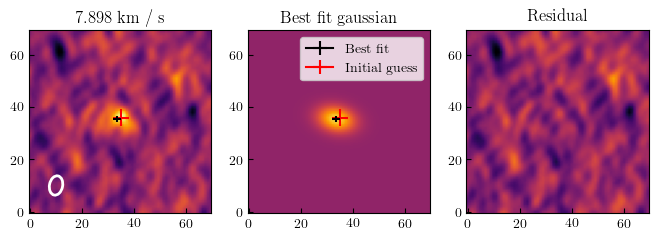

In [8]:
minpix = 9
deltadec = np.abs(smallcubebluemasked.header['CDELT2']) # degrees per pixel
beammajpix = smallcubebluemasked.header['BMAJ'] / deltadec
beamminpix = smallcubebluemasked.header['BMIN'] / deltadec
beampa = smallcubebluemasked.header['BPA']
beamsizepix = beammajpix / 2.35
paramslist = []
errparamslist = []
velocitylistblue = []
with PdfPages(folder + 'fit_channels_blue.pdf') as pdf:
    for chan in range(len(velocitiesblue)):
        mapmasked = smallcubebluemasked.filled_data[chan, :, :]

        if len(np.where(~np.isnan(mapmasked))[0]) < minpix:
            print('Too few pixels to fit')
            continue
            
        else:
            # as we only want to fit a gaussian within the 0.5 inner arcsec, we can fill the rest with noise
            plt.close('all')
            velocity_chan = velocitiesblue[chan]
            maptofit = smallmapblue.unmasked_data[chan, :, :].value
            results = get_2dgaussian_with_errors(maptofit, rms.value, beamsizepix, verbose=True)
            if results is None:
                continue
            params, errparams, xx, yy, zz, initx, inity = results
#             if np.sqrt(params.x_stddev.value**2 + params.y_stddev.value**2)<np.sqrt(2 * beamsizepix**2): # we inmediately save
#                 cmap = 'inferno' #approved
#                 paramslist.append(params)
#                 errparamslist.append(errparams)
#                 velocitylistblue.append(velocity_chan.value)
                
#             else: # we filter by 2 criteria
#                 if distancepix(params.x_mean.value, params.y_mean.value, initx, inity)>np.sqrt(errparams[1]**2+errparams[2]**2):
#                     cmap = 'gist_gray'
#                 elif params.x_stddev.value>2*beamsizepix or params.y_stddev.value>2*beamsizepix:
#                     cmap = 'bone'
#                 else:
            cmap = 'inferno' #approved
            paramslist.append(params)
            errparamslist.append(errparams)
            velocitylistblue.append(velocity_chan.value)
            
            fig = plt.figure(figsize=(8,4))
            ellipse = Ellipse(xy=(10, 10), width=beammajpix, height=beamminpix, angle=beampa+90, edgecolor='w', fc='None', lw=2)
            ax = fig.add_subplot(131)
            vmin = np.amin(maptofit)
            vmax = np.amax(maptofit)
            ax.imshow(maptofit, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
            ax.add_patch(ellipse)
            ax2 = fig.add_subplot(132)
            ax2.imshow(zz, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
            ax3 = fig.add_subplot(133)
            ax3.imshow(maptofit - zz, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
            ax2.errorbar(params.x_mean.value, params.y_mean.value, xerr=errparams[1], yerr=errparams[2], color='k', label='Best fit', zorder=100)
            ax.errorbar(params.x_mean.value, params.y_mean.value, xerr=errparams[1], yerr=errparams[2], color='k', zorder=100)
            ax.errorbar(initx, inity, xerr=beamsizepix, yerr=beamsizepix, color='r')
            ax2.errorbar(initx, inity, xerr=beamsizepix, yerr=beamsizepix, color='r', label='Initial guess')
            ax2.legend()
            ax.set_title(str(np.round(velocity_chan, 3)))
            ax2.set_title('Best fit gaussian' if cmap!='gist_gray' else 'Best fit gaussian (rejected)')
            ax3.set_title('Residual')
            pdf.savefig(bbox_inches='tight')
            #params, errparams, xx, yy, params(xx, yy)


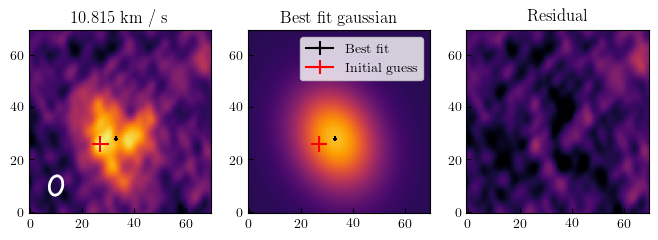

In [9]:
# here we fit the red channels with the same previous criteria
minpix = 9
paramslistred = []
errparamslistred = []
velocitylistred = []
with PdfPages(folder + 'fit_channels_red.pdf') as pdf:
    for chan in range(len(velocitiesred)):
        mapmasked = smallcuberedmasked.filled_data[chan, :, :]

        if len(np.where(~np.isnan(mapmasked))[0]) < minpix:
            print('Too few pixels to fit')
            continue
            
        else:
            # as we only want to fit a gaussian within the 0.5 inner arcsec, we can fill the rest with noise
            plt.close('all')
            velocity_chan = velocitiesred[chan]
            maptofit = smallmapred.unmasked_data[chan, :, :].value
            results = get_2dgaussian_with_errors(maptofit, rms.value, beamsizepix, verbose=True)
            if results is None:
                continue
            params, errparams, xx, yy, zz, initx, inity = results
            # if np.sqrt(params.x_stddev.value**2 + params.y_stddev.value**2)<np.sqrt(2 * beamsizepix**2): # we inmediately save
            cmap = 'inferno' #approved
            paramslistred.append(params)
            errparamslistred.append(errparams)
            velocitylistred.append(velocity_chan.value)
                
#             else: # we filter by 2 criteria
#                 # if distancepix(params.x_mean.value, params.y_mean.value, initx, inity)>np.sqrt(errparams[1]**2+errparams[2]**2):
#                 #     cmap = 'gist_gray'
#                 # if params.x_stddev.value>2*beamsizepix or params.y_stddev.value>2*beamsizepix:
#                 #      cmap = 'bone'
#                 # else:
#                 cmap = 'inferno' #approved
#                 paramslistred.append(params)
#                 errparamslistred.append(errparams)
#                 velocitylistred.append(velocity_chan.value)
            
            fig = plt.figure(figsize=(8,4))
            ellipse = Ellipse(xy=(10, 10), width=beammajpix, height=beamminpix, angle=beampa+90, edgecolor='w', fc='None', lw=2)
            ax = fig.add_subplot(131)
            vmin = np.amin(maptofit)
            vmax = np.amax(maptofit)
            ax.imshow(maptofit, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
            ax.add_patch(ellipse)
            ax2 = fig.add_subplot(132)
            ax2.imshow(zz, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
            ax3 = fig.add_subplot(133)
            ax3.imshow(maptofit - zz, cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
            ax2.errorbar(params.x_mean.value, params.y_mean.value, xerr=errparams[1], yerr=errparams[2], color='k', label='Best fit', zorder=100)
            ax.errorbar(params.x_mean.value, params.y_mean.value, xerr=errparams[1], yerr=errparams[2], color='k', zorder=100)
            ax.errorbar(initx, inity, xerr=beamsizepix, yerr=beamsizepix, color='r')
            ax2.errorbar(initx, inity, xerr=beamsizepix, yerr=beamsizepix, color='r', label='Initial guess')
            ax2.legend()
            ax.set_title(str(np.round(velocity_chan, 3)))
            ax2.set_title('Best fit gaussian' if cmap=='inferno' else 'Best fit gaussian (rejected)')
            ax3.set_title('Residual')
            pdf.savefig(bbox_inches='tight')
            #params, errparams, xx, yy, params(xx, yy)


In [10]:
smallcubehead = smallmapred.header
wcssky = WCS(smallcubehead).celestial
centerxcont, centerycont = wcssky.wcs_world2pix(centerra, centerdec, 0)
centerxcont, centerycont = float(centerxcont), float(centerycont)
velocitylistblue = np.array(velocitylistblue)
velocitylistred = np.array(velocitylistred)

In [11]:
# First we plot the positions we obtained

positionxblue = np.array([params.x_mean.value for params in paramslist])
positionxred = np.array([params.x_mean.value for params in paramslistred])
positionyblue = np.array([params.y_mean.value for params in paramslist])
positionyred = np.array([params.y_mean.value for params in paramslistred])

errpositionxblue = np.array([errparams[1] for errparams in errparamslist])
errpositionxred = np.array([errparams[1] for errparams in errparamslistred])
errpositionyblue = np.array([errparams[2] for errparams in errparamslist])
errpositionyred = np.array([errparams[2] for errparams in errparamslistred])

Text(0, 0.5, 'DEC position (pix)')

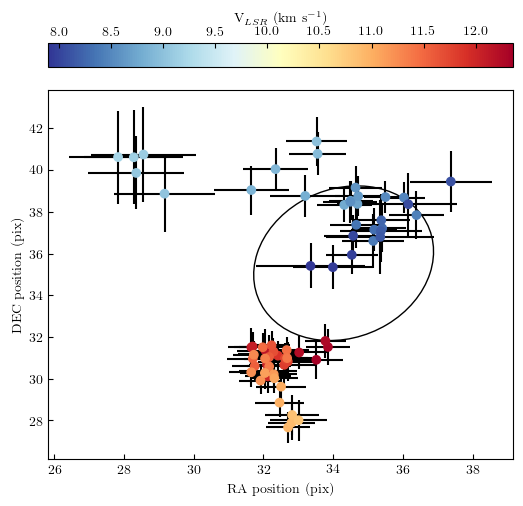

In [12]:
fig = plt.figure(figsize=(6,6))
ellipse = Ellipse(xy=(centerxcont, centerycont), width=beammajpix, height=beamminpix, angle=beampa+90, edgecolor='k', fc='None', lw=1)
ax = fig.add_subplot(111)
sc = ax.scatter(np.concatenate([positionxblue, positionxred]), 
                np.concatenate([positionyblue, positionyred]), 
                c=np.concatenate([velocitylistblue, velocitylistred]), 
                cmap='RdYlBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
sc = ax.errorbar(np.concatenate([positionxblue, positionxred]), 
                np.concatenate([positionyblue, positionyred]), 
                xerr=np.concatenate([errpositionxblue, errpositionxred]), 
                yerr=np.concatenate([errpositionyblue, errpositionyred]),
                color='k', fmt='.')
ax.add_patch(ellipse)
ax.set_xlabel('RA position (pix)')
ax.set_ylabel('DEC position (pix)')
# fig.savefig('figures/position_plot_imageplane.pdf', bbox_inches='tight')

In [13]:
# Lets select the points used to calculate the barycenter
# only the channels with very high velocity are selected
bluelim = 8.8
redlim = 11.1

indexbluecent = np.where(velocitylistblue < bluelim)
indexredcent = np.where(velocitylistred > redlim)

velocitylistblue_sel = velocitylistblue[indexbluecent]
positionxblue_sel = positionxblue[indexbluecent]
positionyblue_sel = positionyblue[indexbluecent]
errpositionxblue_sel = errpositionxblue[indexbluecent]
errpositionyblue_sel = errpositionyblue[indexbluecent]

velocitylistred_sel = velocitylistred[indexredcent]
positionxred_sel = positionxred[indexredcent]
positionyred_sel = positionyred[indexredcent]
errpositionxred_sel = errpositionxred[indexredcent]
errpositionyred_sel = errpositionyred[indexredcent]

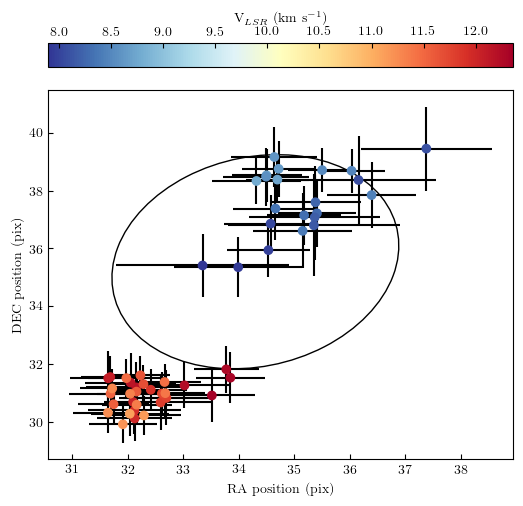

In [14]:
fig = plt.figure(figsize=(6,6))
ellipse = Ellipse(xy=(centerxcont, centerycont), width=beammajpix, height=beamminpix, angle=beampa+90, edgecolor='k', fc='None', lw=1)

ax = fig.add_subplot(111)
sc = ax.scatter(np.concatenate([positionxblue_sel, positionxred_sel]), 
                np.concatenate([positionyblue_sel, positionyred_sel]), 
                c=np.concatenate([velocitylistblue_sel, velocitylistred_sel]), 
                cmap='RdYlBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
sc = ax.errorbar(np.concatenate([positionxblue_sel, positionxred_sel]), 
                np.concatenate([positionyblue_sel, positionyred_sel]), 
                xerr=np.concatenate([errpositionxblue_sel, errpositionxred_sel]), 
                yerr=np.concatenate([errpositionyblue_sel, errpositionyred_sel]),
                color='k', fmt='.')
ax.set_xlabel('RA position (pix)')
ax.set_ylabel('DEC position (pix)')
ax.add_patch(ellipse)

In [15]:
# Here we obtain the barycenter

averagebluex = np.average(positionxblue_sel, weights=errpositionxblue_sel)
averagebluey = np.average(positionyblue_sel, weights=errpositionyblue_sel)
averageredx = np.average(positionxred_sel, weights=errpositionxred_sel)
averageredy = np.average(positionyred_sel, weights=errpositionyred_sel)

centerxcorr = (averagebluex + averageredx) / 2
centerycorr = (averagebluey + averageredy) / 2

centerxcorr_sky, centerycorr_sky = wcssky.wcs_pix2world(centerxcorr, centerycorr, 0)
centerxcorr_sky, centerycorr_sky = float(centerxcorr_sky), float(centerycorr_sky)
if not os.path.exists(folder+'barycenter_position_sky.npy'):
    np.save(folder+'barycenter_position_sky', np.array([centerxcorr_sky, centerycorr_sky]))

In [16]:
# corrections
# positions with respect to conrrected center
positionxblue_arcsec = ((positionxblue - centerxcorr) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
positionxred_arcsec = ((positionxred - centerxcorr) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
positionyblue_arcsec = ((positionyblue - centerycorr) * deltadec) * 3600
positionyred_arcsec = ((positionyred - centerycorr) * deltadec) * 3600

errpositionxblue_arcsec = ((errpositionxblue) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
errpositionxred_arcsec = ((errpositionxred) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
errpositionyblue_arcsec = ((errpositionyblue) * deltadec) * 3600
errpositionyred_arcsec = ((errpositionyred) * deltadec) * 3600

# distances from center
distancesblue = distancepix(positionxblue, positionyblue, centerxcorr, centerycorr)
distancesred = distancepix(positionxred, positionyred, centerxcorr, centerycorr)
errdistancesblue = np.sqrt((errpositionxblue/positionxblue)**2 + (errpositionyblue/positionyblue)**2) * distancesblue
errdistancesred = np.sqrt((errpositionxred/positionxred)**2 + (errpositionyred/positionyred)**2) * distancesred

distancesblue_arcsec = distancepix(positionxblue_arcsec, positionyblue_arcsec, 0, 0)
distancesred_arcsec = distancepix(positionxred_arcsec, positionyred_arcsec, 0, 0)
errdistancesblue_arcsec = distancepix(errpositionxblue_arcsec, errpositionyblue_arcsec, 0, 0)
errdistancesred_arcsec = distancepix(errpositionxred_arcsec, errpositionyred_arcsec, 0, 0)


In [17]:
# These are the distances we save
if not os.path.exists(folder+'positions_displacement_arcsec_blue.npy'):
    np.save(folder+'positions_displacement_arcsec_blue', np.array([velocitylistblue, positionxblue_arcsec, positionyblue_arcsec, errpositionxblue_arcsec, errpositionyblue_arcsec]))
if not os.path.exists(folder+'positions_displacement_arcsec_red.npy'):
    np.save(folder+'positions_displacement_arcsec_red', np.array([velocitylistred, positionxred_arcsec, positionyred_arcsec, errpositionxred_arcsec, errpositionyred_arcsec]))


Text(0, 0.5, 'DEC displacement (arcsec)')

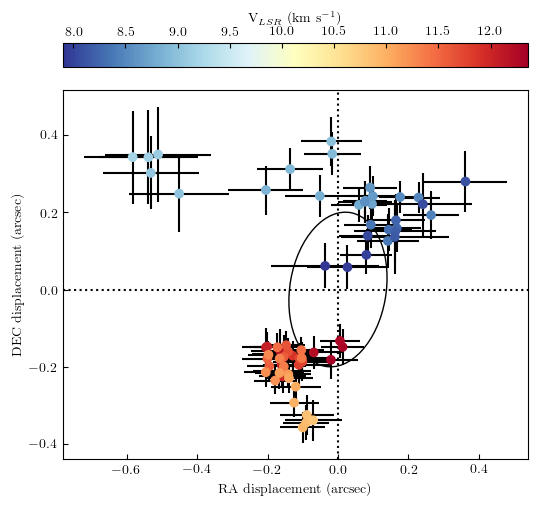

In [18]:
fig = plt.figure(figsize=(6,6))
ellipse = Ellipse(xy=(0, 0), width=beammajpix* 3600*deltadec, height=beamminpix* 3600*deltadec, angle=beampa+90, edgecolor='k', fc='None', lw=1)
ax = fig.add_subplot(111)
sc = ax.scatter(np.concatenate([positionxblue_arcsec, positionxred_arcsec]), 
                np.concatenate([positionyblue_arcsec, positionyred_arcsec]), 
                c=np.concatenate([velocitylistblue, velocitylistred]), 
                cmap='RdYlBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
sc = ax.errorbar(np.concatenate([positionxblue_arcsec, positionxred_arcsec]), 
                np.concatenate([positionyblue_arcsec, positionyred_arcsec]), 
                xerr=np.concatenate([errpositionxblue_arcsec, errpositionxred_arcsec]), 
                yerr=np.concatenate([errpositionyblue_arcsec, errpositionyred_arcsec]),
                color='k', fmt='.')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.add_patch(ellipse)
ax.set_xlabel('RA displacement (arcsec)')
ax.set_ylabel('DEC displacement (arcsec)')
# fig.savefig('figures/displacement_plot_imageplane.pdf', bbox_inches='tight')

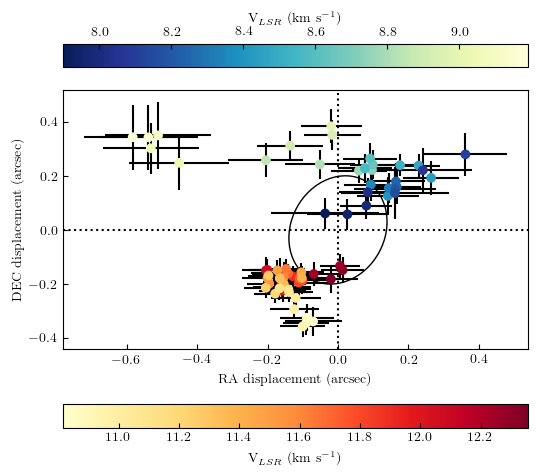

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ellipse = Ellipse(xy=(0, 0), width=beammajpix* 3600*deltadec, height=beamminpix* 3600*deltadec, angle=beampa+90, edgecolor='k', fc='None', lw=1)
sc = ax.scatter(positionxblue_arcsec, positionyblue_arcsec, 
                c=velocitylistblue, 
                cmap='YlGnBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
ax.errorbar(positionxblue_arcsec, positionyblue_arcsec, 
                xerr=errpositionxblue_arcsec, 
                yerr=errpositionyblue_arcsec,
                color='k', fmt='.')
sc2 = ax.scatter(positionxred_arcsec, positionyred_arcsec, 
                c=velocitylistred, 
                cmap='YlOrRd', zorder=100)
plt.colorbar(sc2, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='bottom')
ax.errorbar(positionxred_arcsec, positionyred_arcsec, 
                xerr=errpositionxred_arcsec, 
                yerr=errpositionyred_arcsec,
                color='k', fmt='.')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.set_xlabel('RA displacement (arcsec)')
ax.set_ylabel('DEC displacement (arcsec)')
ax.add_patch(ellipse)
# fig.savefig('figures/displacement_plot_imageplane_alt_cbar.pdf', bbox_inches='tight')

In [23]:
# Here we estimate the upper and lower limits for the mass from these points
distancesblue_au = distancesblue_arcsec * dist_B5.value
distancesred_au = distancesred_arcsec * dist_B5.value
errdistancesblue_au = errdistancesblue_arcsec * dist_B5.value
errdistancesred_au = errdistancesred_arcsec * dist_B5.value

if not os.path.exists(folder+'distances_displacement_au_blue.npy'):
    np.save(folder+'distances_displacement_au_blue.npy', np.array([distancesblue_au, errdistancesblue_au]))
    
if not os.path.exists(folder+'distances_displacement_au_red.npy'):
    np.save(folder+'distances_displacement_au_red.npy', np.array([distancesred_au, errdistancesred_au]))

In [21]:
radius_au = np.linspace(10, 500) * u.au
M_star = np.array([0.2, 0.3]) * u.Msun
vel_kep_mass = np.array([v_kepler(mass, radius_au).decompose().to(u.km/u.s).value for mass in M_star])
M_star_BB = 0.1 * u.Msun
vel_kep_BB = v_kepler(M_star_BB, radius_au).decompose().to(u.km/u.s).value

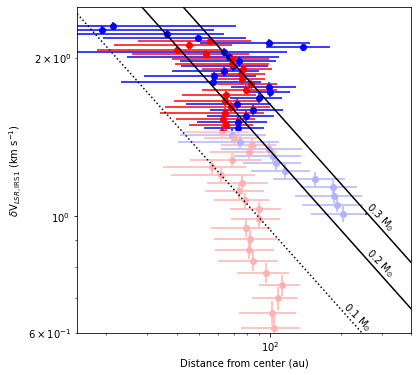

In [24]:
savefigure = True
radius_au = np.linspace(10, 500) * u.au
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.errorbar(distancesblue_au, -1*(np.array(velocitylistblue)-10.2), xerr=errdistancesblue_au, yerr=velerror, color='b', fmt='o')
ax.errorbar(distancesred_au, np.array(velocitylistred)-10.2, xerr=errdistancesred_au, yerr=velerror, color='r', fmt='o')
radius_label = 250
vel_index = np.argmin(np.abs(radius_au.value-radius_label))
for i, mass in enumerate(M_star):
    ax.plot(radius_au, vel_kep_mass[i], color='k', ls='-', label=str(mass), zorder=300)
    
    vel_label = vel_kep_mass[i][vel_index] 
    ax.annotate(str(mass.value)+r' M$_{\odot}$', xy=(radius_label, vel_label), xytext=(2,2), textcoords="offset points", 
                rotation_mode='anchor', rotation=-45, zorder=300)

ax.plot(radius_au, vel_kep_BB, color='k', ls=':', zorder=300)
radius_label = 200
vel_index = np.argmin(np.abs(radius_au.value-radius_label))
vel_label = vel_kep_BB[vel_index] 
ax.annotate(str(M_star_BB.value)+r' M$_{\odot}$', xy=(radius_label, vel_label), xytext=(2,2), textcoords="offset points", 
                rotation_mode='anchor', rotation=-45, zorder=300)
ax.set_xlabel('Distance from center (au)')
ax.set_ylabel(r'$\delta$V$_{LSR, \mathrm{IRS1}}$ (km s$^{-1}$)')
ax.set_xlim([15, 400])
ax.set_ylim([0.6, 2.5])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.axhline(10.2-8.75, color='b', linestyle='dashed')
# ax.axhline(11.57-10.2, color='r', linestyle='dashed')
ax.fill_between([20, 250], 0.05, 10.2-8.75, color='w', alpha=0.7, zorder=100) # where there is considerable extended emission affecting the fit
# if savefigure: fig.savefig('figures/displacement_plot_radius_au_all.pdf', bbox_inches='tight')

### What if we do this comparison without using the barycenter?

In [24]:

# positions with respect to the center in KA-band from Tobin et al 2016 catalog
positionxblue_arcsecb5 = ((positionxblue - centerxcont) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
positionxred_arcsecb5 = ((positionxred - centerxcont) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
positionyblue_arcsecb5 = ((positionyblue - centerycont) * deltadec) * 3600
positionyred_arcsecb5 = ((positionyred - centerycont) * deltadec) * 3600

errpositionxblue_arcsecb5 = ((errpositionxblue) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
errpositionxred_arcsecb5 = ((errpositionxred) * -smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600
errpositionyblue_arcsecb5 = ((errpositionyblue) * deltadec) * 3600
errpositionyred_arcsecb5 = ((errpositionyred) * deltadec) * 3600

# distances from center
distancesblueb5 = distancepix(positionxblue, positionyblue, centerxcont, centerycont)
distancesredb5 = distancepix(positionxred, positionyred, centerxcont, centerycont)
errdistancesblueb5 = np.sqrt((errpositionxblue/positionxblue)**2 + (errpositionyblue/positionyblue)**2) * distancesblue
errdistancesredb5 = np.sqrt((errpositionxred/positionxred)**2 + (errpositionyred/positionyred)**2) * distancesred

distancesblue_arcsecb5 = distancepix(positionxblue_arcsecb5, positionyblue_arcsecb5, 0, 0)
distancesred_arcsecb5 = distancepix(positionxred_arcsecb5, positionyred_arcsecb5, 0, 0)
errdistancesblue_arcsecb5 = distancepix(errpositionxblue_arcsecb5, errpositionyblue_arcsecb5, 0, 0)
errdistancesred_arcsecb5 = distancepix(errpositionxred_arcsecb5, errpositionyred_arcsecb5, 0, 0)

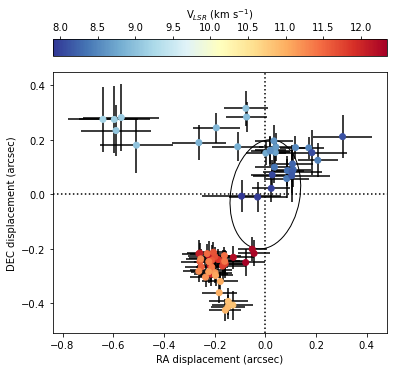

In [25]:
savefigure = False
fig = plt.figure(figsize=(6,6))
ellipse = Ellipse(xy=(0, 0), width=beammajpix* 3600*deltadec, height=beamminpix* 3600*deltadec, angle=beampa+90, edgecolor='k', fc='None', lw=1)
ax = fig.add_subplot(111)
sc = ax.scatter(np.concatenate([positionxblue_arcsecb5, positionxred_arcsecb5]), 
                np.concatenate([positionyblue_arcsecb5, positionyred_arcsecb5]), 
                c=np.concatenate([velocitylistblue, velocitylistred]), 
                cmap='RdYlBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
sc = ax.errorbar(np.concatenate([positionxblue_arcsecb5, positionxred_arcsecb5]), 
                np.concatenate([positionyblue_arcsecb5, positionyred_arcsecb5]), 
                xerr=np.concatenate([errpositionxblue_arcsecb5, errpositionxred_arcsecb5]), 
                yerr=np.concatenate([errpositionyblue_arcsecb5, errpositionyred_arcsecb5]),
                color='k', fmt='.')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.add_patch(ellipse)
ax.set_xlabel('RA displacement (arcsec)')
ax.set_ylabel('DEC displacement (arcsec)')
# if savefigure:
#     fig.savefig('figures/displacement_plot_imageplane_b5center.pdf', bbox_inches='tight')

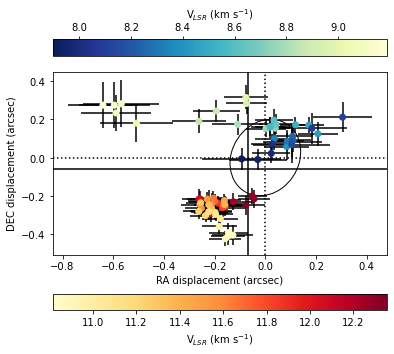

In [30]:
savefigure = False
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ellipse = Ellipse(xy=(0, 0), width=beammajpix* 3600*deltadec, height=beamminpix* 3600*deltadec, angle=beampa+90, edgecolor='k', fc='None', lw=1)
sc = ax.scatter(positionxblue_arcsecb5, positionyblue_arcsecb5, 
                c=velocitylistblue, 
                cmap='YlGnBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
ax.errorbar(positionxblue_arcsecb5, positionyblue_arcsecb5, 
                xerr=errpositionxblue_arcsecb5, 
                yerr=errpositionyblue_arcsecb5,
                color='k', fmt='.')
sc2 = ax.scatter(positionxred_arcsecb5, positionyred_arcsecb5, 
                c=velocitylistred, 
                cmap='YlOrRd', zorder=100)
plt.colorbar(sc2, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='bottom')
ax.errorbar(positionxred_arcsecb5, positionyred_arcsecb5, 
                xerr=errpositionxred_arcsecb5, 
                yerr=errpositionyred_arcsecb5,
                color='k', fmt='.')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.axhline((centerxcorr-centerxcont)* (-smallcubehead['CDELT1']/np.cos(smallcubehead['CRVAL1']*np.pi/180.)) * 3600, color='k')
ax.axvline((centerycorr-centerycont)* deltadec * 3600, color='k')
ax.set_xlabel('RA displacement (arcsec)')
ax.set_ylabel('DEC displacement (arcsec)')
ax.add_patch(ellipse)
if savefigure:
    fig.savefig('figures/displacement_plot_imageplane_alt_cbar_b5.pdf', bbox_inches='tight')

In [33]:
# Here we estimate the upper and lower limits for the mass from these points
distancesblue_aub5 = distancesblue_arcsecb5 * dist_B5.value
distancesred_aub5 = distancesred_arcsecb5 * dist_B5.value
errdistancesblue_aub5 = errdistancesblue_arcsecb5 * dist_B5.value
errdistancesred_aub5 = errdistancesred_arcsecb5 * dist_B5.value

radius_au = np.linspace(10, 500) * u.au
M_star = np.array([0.2, 0.3]) * u.Msun
vel_kep_mass = np.array([v_kepler(mass, radius_au).decompose().to(u.km/u.s).value for mass in M_star])
M_star_BB = 0.1 * u.Msun
vel_kep_BB = v_kepler(M_star_BB, radius_au).decompose().to(u.km/u.s).value

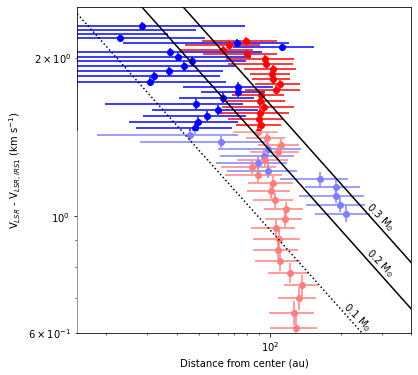

In [41]:
radius_au = np.linspace(10, 500) * u.au
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.errorbar(distancesblue_aub5, -1*(np.array(velocitylistblue)-10.2), xerr=errdistancesblue_aub5, yerr=velerror, color='b', fmt='o')
ax.errorbar(distancesred_aub5, np.array(velocitylistred)-10.2, xerr=errdistancesred_aub5, yerr=velerror, color='r', fmt='o')
radius_label = 250
vel_index = np.argmin(np.abs(radius_au.value-radius_label))
for i, mass in enumerate(M_star):
    ax.plot(radius_au, vel_kep_mass[i], color='k', ls='-', label=str(mass), zorder=300)
    
    vel_label = vel_kep_mass[i][vel_index] 
    ax.annotate(str(mass.value)+r' M$_{\odot}$', xy=(radius_label, vel_label), xytext=(2,2), textcoords="offset points", 
                rotation_mode='anchor', rotation=-45, zorder=300)

ax.plot(radius_au, vel_kep_BB, color='k', ls=':', zorder=300)
radius_label = 200
vel_index = np.argmin(np.abs(radius_au.value-radius_label))
vel_label = vel_kep_BB[vel_index] 
ax.annotate(str(M_star_BB.value)+r' M$_{\odot}$', xy=(radius_label, vel_label), xytext=(2,2), textcoords="offset points", 
                rotation_mode='anchor', rotation=-45, zorder=300)
ax.set_xlabel('Distance from center (au)')
ax.set_ylabel(r'V$_{LSR}$ - V$_{LSR, IRS1}$ (km s$^{-1}$)')
ax.set_xlim([15, 400])
ax.set_ylim([0.6, 2.5])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.axhline(10.2-8.75, color='b', linestyle='dashed')
# ax.axhline(11.57-10.2, color='r', linestyle='dashed')
ax.fill_between(radius_au, 0.05, 10.2-8.75, color='w', alpha=0.5, zorder=100) # where there is considerable extended emission affecting the fit
fig.savefig('figures/displacement_plot_radius_au_all_b5.pdf', bbox_inches='tight')